In [1]:
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from tqdm.notebook import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import subprocess
import imageio
import multiprocessing
import insightface
import logging



d:\conda\envs\ml\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Zicky/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Zicky/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Zicky/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Zicky/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Zicky/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

Processing frames:   0%|          | 0/130 [00:00<?, ?it/s]

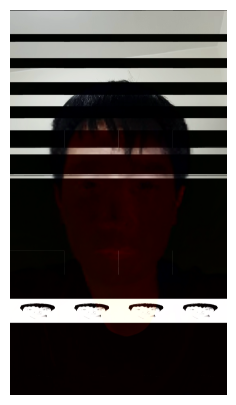

Final output saved to d:\研究生\cv\project\myself_swapped.mp4
Finished processing D:/study/cv/project/myself.mp4


In [ ]:
# Suppressing imageio ffmpeg warnings
logging.getLogger().setLevel(logging.ERROR)

def init_superres_model(model_path='ESPCN_x4.pb'):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel('espcn', 4)  
    return sr

class FaceSwapper:
    def __init__(self, app_name='buffalo_l', model_path=None, ffmpeg_path=None, superres_model_path=None):
        self.app = insightface.app.FaceAnalysis(name=app_name)
        self.app.prepare(ctx_id=0, det_size=(640, 640))
        self.swapper = insightface.model_zoo.get_model(model_path, download=False, download_zip=False)
        self.ffmpeg_path = ffmpeg_path
        if superres_model_path:
            self.sr = init_superres_model(superres_model_path)
        else:
            self.sr = None

    def _apply_superres(self, frame):
        if self.sr is not None:
            frame = self.sr.upsample(frame)
        return frame

    def _process_frame(self, frame, face1):
        if frame is None:
            return None, False
        
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        face2_result = self.app.get(frame_bgr)
        if face2_result is None or not face2_result:
            return None, None
        face2 = face2_result[0]
        frame_swapped = self.swapper.get(frame_bgr, face2, face1, paste_back=True)
        if frame_swapped is None:
            return None, False
        
        frame_swapped_rgb = cv2.cvtColor(frame_swapped, cv2.COLOR_BGR2RGB)
        frame_swapped_rgb = self._apply_superres(frame_swapped_rgb)  # 应用超分辨率
        return frame_swapped_rgb, True

    def swap_n_show(self, img1_fn, video_fn):
        img1 = cv2.imread(img1_fn)
        face1 = self.app.get(img1)[0]
        video = imageio.get_reader(video_fn)
        fps = video.get_meta_data()['fps']

        with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
            futures = [executor.submit(self._process_frame, frame, face1) for frame in video]
            results = []
            for future in tqdm(futures, total=len(futures), desc='Processing frames'):
                results.append(future.result())

        swapped_video, status_list = zip(*results)
        swapped_video = [frame for frame, status in zip(swapped_video, status_list) if status]

        if swapped_video:
            self._handle_video_processing(video_fn, swapped_video, fps)

    def _handle_video_processing(self, video_fn, swapped_video, fps):
        input_path = Path(video_fn)
        extension = input_path.suffix.lower()

        if extension in ['.mp4', '.mov']:
            video_codec = 'libx264'
            audio_codec = 'aac'
            audio_extension = '.m4a'
            output_extension = '.mp4'
        elif extension == '.webm':
            video_codec = 'libvpx-vp9'
            audio_codec = 'libvorbis'
            audio_extension = '.ogg'
            output_extension = '.mp4'
        else:
            raise ValueError("Unsupported video format")

        output_video_fn = str(input_path.stem) + '_output' + output_extension
        output_path = Path.cwd() / output_video_fn

        with imageio.get_writer(output_path, fps=fps, codec=video_codec, quality=9, ffmpeg_params=['-vf', 'scale=trunc(iw/2)*2:trunc(ih/2)*2']) as writer:
            for frame in swapped_video:
                if frame is not None:
                    writer.append_data(frame)

        audio_fn = str(input_path.stem) + '_audio' + audio_extension
        subprocess.run([self.ffmpeg_path, '-i', video_fn, '-vn', '-acodec', audio_codec, audio_fn, '-y'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        final_output_fn = str(input_path.stem) + '_swapped' + output_extension
        final_output_path = Path.cwd() / final_output_fn
        subprocess.run([self.ffmpeg_path, '-i', output_path, '-i', audio_fn, '-c:v', 'copy', '-c:a', 'copy', '-shortest', final_output_path, '-y'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        os.remove(output_path)
        os.remove(audio_fn)

        plt.figure(figsize=(5, 5))
        plt.imshow(swapped_video[0])
        plt.axis('off')
        plt.show()

        print(f"Final output saved to {final_output_path}")

def main():
    model_path = 'D:/work/plug/inswapper_128.onnx'
    ffmpeg_path = 'D:/work/plug/ffmpeg-7.0.2-essentials_build/bin/ffmpeg'
    superres_model_path = 'D:/study/cv/project/ESPCN_x4.pb'
    swapper = FaceSwapper(model_path=model_path, ffmpeg_path=ffmpeg_path, superres_model_path=superres_model_path)

    image_path = 'D:/study/cv/project/wyz.jpg'
    # video_path = 'D:/study/cv/project/videos/'
    video_path = 'D:/study/cv/project/myself.mp4'
    video_files = [f'videos_{i}.mp4' for i in range(0, 1)]

    # for video_file in video_files:
    #     print(f"Processing {video_file}...")
    #     full_video_path = os.path.join(video_path, video_file)
    #     try:
    #         swapper.swap_n_show(image_path, full_video_path)
    #         print(f"Finished processing {video_file}")
    #     except Exception as e:
    #         print(f"Failed to process {video_file}: {e}")

    try:
        swapper.swap_n_show(image_path, video_path)
        print(f"Finished processing {video_path}")
    except Exception as e:
        print(f"Failed to process {video_path}: {e}")

if __name__ == "__main__":
    main()